# HW4: Recurrent Neural Network
Yu-Kai "Steven" Wang

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import pickle
from matplotlib import pyplot as plt

## Task 1: RNN

For this homework I am using the "Daily minimum temperatures in Melbourne, Australia, 1981-1990" dataset. Download [here](https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv).

The problem I would like to solve is given the temperature of the past 120 days, predict next day's minimum temperature. The problem requires a sequential model since a normal feed foward network will disregard the order of the input. Date will not be used as a feature to simplify the process.

For the train / valid / test split, I have manually split the CSV file into three files (80% / 10% / 10%) correspondly. 

I will be using PyTorch for the implementation of this model.

**Dataset**

Read data from CSV file. Temperature data is normalized. 

In [3]:
class MinDailyTempDataset(Dataset):
    def __init__(self, filename, L, norm = False):
        super().__init__()
        self.L = L
        self.seq = self.readcsv(filename)
        if norm:
            # normalize data
            self.seq = self.seq / torch.max(self.seq)
    
    def readcsv(self, filename):
        sequence = []
        isFirst = True
        with open(filename) as f:
            for row in f:
                if isFirst:
                    isFirst = False
                    continue
                data = float(row.strip().split(',')[1])
                sequence.append(data)
        return torch.tensor(sequence)
    
    def __getitem__(self, idx):
        return self.seq[idx: idx + self.L].unsqueeze(-1), self.seq[idx + self.L].unsqueeze(-1)
        
    def __len__(self):
        return self.seq.shape[0] - self.L

In [4]:
frame_size = 120

# create train / valid / test dataset
train_dataset = MinDailyTempDataset('../data/MIN_DAILY_TEMP/daily-min-temperatures-train.csv', frame_size, norm = True)
print(f'{len(train_dataset)} data points in total for training.')
valid_dataset = MinDailyTempDataset('../data/MIN_DAILY_TEMP/daily-min-temperatures-valid.csv', frame_size, norm = True)
print(f'{len(valid_dataset)} data points in total for validating.')
test_dataset = MinDailyTempDataset('../data/MIN_DAILY_TEMP/daily-min-temperatures-test.csv', frame_size, norm = True)
print(f'{len(test_dataset)} data points in total for testing.')

2810 data points in total for training.
240 data points in total for validating.
240 data points in total for testing.


**Data Visualization**

Plot of training dataset

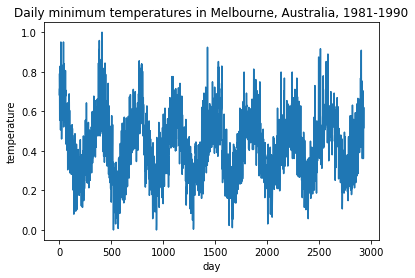

In [5]:
plt.plot(np.arange(train_dataset.seq.shape[0]), train_dataset.seq)
plt.title('Daily minimum temperatures in Melbourne, Australia, 1981-1990')
plt.xlabel('day')
plt.ylabel('temperature')
plt.show()

**Evaluation Metric**

For this model I will be using the MSE loss as the evaluation metric.

**RNN / GRU / LSTM Model**

In [6]:
class Model(nn.Module):
    '''
    Simple RNN model with stacked RNN followed by two linear layers
    '''
    def __init__(self, L, hidden_size = 32, hidden_size_2 = 64, num_layers = 2, drop = 0, mode = 'RNN'):
        super().__init__()
        if mode == 'GRU':
            self.rnn = nn.GRU(input_size = 1, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = drop)
        elif mode == 'LSTM':
            self.rnn = nn.LSTM(input_size = 1, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = drop)
        else: # default to RNN
            self.rnn = nn.RNN(input_size = 1, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = drop)
        self.flatten = nn.Flatten()
        self.f1 = nn.Linear(L * hidden_size, hidden_size_2)
        self.f2 = nn.Linear(hidden_size_2, 1)
    
    def forward(self, x):
        out, hn = self.rnn(x)
        x = self.flatten(out)
        x = self.f1(x)
        x = F.relu(x)
        x = self.f2(x)
        return x

**Training RNN**

In [7]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 16

modelRNN = Model(frame_size, hidden_size = 64, hidden_size_2 = 64, num_layers = 3, drop = 0.5, mode = 'RNN')
modelRNN.to(device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
optimizer = optim.Adam(modelRNN.parameters(), lr = 0.001)
modelRNN.train()

Model(
  (rnn): RNN(1, 64, num_layers=3, batch_first=True, dropout=0.5)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (f1): Linear(in_features=7680, out_features=64, bias=True)
  (f2): Linear(in_features=64, out_features=1, bias=True)
)

In [8]:
loss_rnn = []
for epoch in range(100):
    sum_loss = 0
    for b_idx, (data, labels) in enumerate(train_loader):
        
        # zero out gradient
        optimizer.zero_grad()

        # send batch to device
        data, labels = data.to(device), labels.to(device)

        # foward pass
        pred = modelRNN(data)

        # cross entropy loss
        loss = F.mse_loss(pred, labels)

        # back propagation
        loss.backward()
        sum_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, train loss: {sum_loss / batch_size}')
    loss_rnn.append(sum_loss / batch_size)

Epoch 0, train loss: 0.25977685127872974
Epoch 1, train loss: 0.1562211506825406
Epoch 2, train loss: 0.13820251659490168
Epoch 3, train loss: 0.13474653774756007
Epoch 4, train loss: 0.1283689314732328
Epoch 5, train loss: 0.12107354354520794
Epoch 6, train loss: 0.11469134136859793
Epoch 7, train loss: 0.12074937266879715
Epoch 8, train loss: 0.11108820082154125
Epoch 9, train loss: 0.10648922811378725
Epoch 10, train loss: 0.11017910494410899
Epoch 11, train loss: 0.10613184451358393
Epoch 12, train loss: 0.10533797178504756
Epoch 13, train loss: 0.10735938019206515
Epoch 14, train loss: 0.10397425886185374
Epoch 15, train loss: 0.10411487134115305
Epoch 16, train loss: 0.10471982973103877
Epoch 17, train loss: 0.10206359061703552
Epoch 18, train loss: 0.10447922105959151
Epoch 19, train loss: 0.10034499490575399
Epoch 20, train loss: 0.10201481795229483
Epoch 21, train loss: 0.10140605106425937
Epoch 22, train loss: 0.10185496610938571
Epoch 23, train loss: 0.10129174169560429
Epoc

**Validation loss**

In [9]:
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
modelRNN.eval()
sum_loss = 0
for b_idx, (data, labels) in enumerate(valid_loader):

    # send batch to device
    data, labels = data.to(device), labels.to(device)

    # foward pass
    pred = modelRNN(data)

    # cross entropy loss
    loss = F.mse_loss(pred, labels)

    sum_loss += loss.item()
print(f'Validation loss: {sum_loss / batch_size}')

Validation loss: 0.01595030474709347


**Test loss**

In [10]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
modelRNN.eval()
sum_loss = 0
for b_idx, (data, labels) in enumerate(test_loader):

    # send batch to device
    data, labels = data.to(device), labels.to(device)

    # foward pass
    pred = modelRNN(data)

    # cross entropy loss
    loss = F.mse_loss(pred, labels)

    sum_loss += loss.item()
print(f'Test loss: {sum_loss / batch_size}')

Test loss: 0.017284068395383656


**Training GRU**

In [11]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 16

modelGRU = Model(frame_size, hidden_size = 64, hidden_size_2 = 64, num_layers = 3, drop = 0.5, mode = 'GRU')
modelGRU.to(device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
optimizer = optim.Adam(modelGRU.parameters(), lr = 0.001)
modelGRU.train()

Model(
  (rnn): GRU(1, 64, num_layers=3, batch_first=True, dropout=0.5)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (f1): Linear(in_features=7680, out_features=64, bias=True)
  (f2): Linear(in_features=64, out_features=1, bias=True)
)

In [12]:
loss_gru = []
for epoch in range(100):
    sum_loss = 0
    for b_idx, (data, labels) in enumerate(train_loader):
        
        # zero out gradient
        optimizer.zero_grad()

        # send batch to device
        data, labels = data.to(device), labels.to(device)

        # foward pass
        pred = modelGRU(data)

        # cross entropy loss
        loss = F.mse_loss(pred, labels)

        # back propagation
        loss.backward()
        sum_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, train loss: {sum_loss / batch_size}')
    loss_gru.append(sum_loss / batch_size)

Epoch 0, train loss: 0.23831102397525683
Epoch 1, train loss: 0.1465976214967668
Epoch 2, train loss: 0.14429895325156394
Epoch 3, train loss: 0.14157268452981953
Epoch 4, train loss: 0.13555476479814388
Epoch 5, train loss: 0.13338578585535288
Epoch 6, train loss: 0.13294743941514753
Epoch 7, train loss: 0.12844943834352307
Epoch 8, train loss: 0.12166788714239374
Epoch 9, train loss: 0.11781367019284517
Epoch 10, train loss: 0.11426387092797086
Epoch 11, train loss: 0.10811277480388526
Epoch 12, train loss: 0.10573235245828982
Epoch 13, train loss: 0.10708516398153733
Epoch 14, train loss: 0.10631462096353061
Epoch 15, train loss: 0.10033407554146834
Epoch 16, train loss: 0.10094224562635645
Epoch 17, train loss: 0.10169728414621204
Epoch 18, train loss: 0.1034298488375498
Epoch 19, train loss: 0.10374469881935511
Epoch 20, train loss: 0.09812068881001323
Epoch 21, train loss: 0.10786914551863447
Epoch 22, train loss: 0.10176358696480747
Epoch 23, train loss: 0.09902273818443064
Epoc

**Validation Loss**

In [13]:
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
modelGRU.eval()
sum_loss = 0
for b_idx, (data, labels) in enumerate(valid_loader):

    # send batch to device
    data, labels = data.to(device), labels.to(device)

    # foward pass
    pred = modelGRU(data)

    # cross entropy loss
    loss = F.mse_loss(pred, labels)

    sum_loss += loss.item()
print(f'Validation loss: {sum_loss / batch_size}')

Validation loss: 0.013975500856759027


**Test Loss**

In [14]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
modelGRU.eval()
sum_loss = 0
for b_idx, (data, labels) in enumerate(test_loader):

    # send batch to device
    data, labels = data.to(device), labels.to(device)

    # foward pass
    pred = modelGRU(data)

    # cross entropy loss
    loss = F.mse_loss(pred, labels)

    sum_loss += loss.item()
print(f'Test loss: {sum_loss / batch_size}')

Test loss: 0.01674424431985244


**Training LSTM**

In [33]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 16

modelLSTM = Model(frame_size, hidden_size = 64, hidden_size_2 = 64, num_layers = 3, drop = 0.5, mode = 'LSTM')
modelLSTM.to(device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
optimizer = optim.Adam(modelLSTM.parameters(), lr = 0.001)
modelLSTM.train()

Model(
  (rnn): LSTM(1, 64, num_layers=3, batch_first=True, dropout=0.5)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (f1): Linear(in_features=7680, out_features=64, bias=True)
  (f2): Linear(in_features=64, out_features=1, bias=True)
)

In [34]:
loss_lstm = []
for epoch in range(100):
    sum_loss = 0
    for b_idx, (data, labels) in enumerate(train_loader):
        
        # zero out gradient
        optimizer.zero_grad()

        # send batch to device
        data, labels = data.to(device), labels.to(device)

        # foward pass
        pred = modelLSTM(data)

        # cross entropy loss
        loss = F.mse_loss(pred, labels)

        # back propagation
        loss.backward()
        sum_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, train loss: {sum_loss / batch_size}')
    loss_lstm.append(sum_loss / batch_size)

Epoch 0, train loss: 0.24706983364012558
Epoch 1, train loss: 0.14180795344873331
Epoch 2, train loss: 0.1434289960307069
Epoch 3, train loss: 0.13510030605539214
Epoch 4, train loss: 0.13932269703946076
Epoch 5, train loss: 0.1337851506541483
Epoch 6, train loss: 0.13263631716836244
Epoch 7, train loss: 0.13296515890397131
Epoch 8, train loss: 0.13049250995391048
Epoch 9, train loss: 0.1291362291231053
Epoch 10, train loss: 0.12246084639627952
Epoch 11, train loss: 0.11824281439476181
Epoch 12, train loss: 0.12106049571593758
Epoch 13, train loss: 0.10879592232231516
Epoch 14, train loss: 0.10922164397197776
Epoch 15, train loss: 0.1037989423784893
Epoch 16, train loss: 0.10291971277911216
Epoch 17, train loss: 0.10200805159547599
Epoch 18, train loss: 0.10131152642134111
Epoch 19, train loss: 0.10095237540372182
Epoch 20, train loss: 0.0982340096088592
Epoch 21, train loss: 0.09890071980771609
Epoch 22, train loss: 0.10098611353896558
Epoch 23, train loss: 0.0959753983115661
Epoch 24

**Validation Loss**

In [35]:
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
modelLSTM.eval()
sum_loss = 0
for b_idx, (data, labels) in enumerate(valid_loader):

    # send batch to device
    data, labels = data.to(device), labels.to(device)

    # foward pass
    pred = modelLSTM(data)

    # cross entropy loss
    loss = F.mse_loss(pred, labels)

    sum_loss += loss.item()
print(f'Validation loss: {sum_loss / batch_size}')

Validation loss: 0.014417543454328552


**Test Loss**

In [36]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
modelLSTM.eval()
sum_loss = 0
for b_idx, (data, labels) in enumerate(test_loader):

    # send batch to device
    data, labels = data.to(device), labels.to(device)

    # foward pass
    pred = modelLSTM(data)

    # cross entropy loss
    loss = F.mse_loss(pred, labels)

    sum_loss += loss.item()
print(f'Test loss: {sum_loss / batch_size}')

Test loss: 0.014970951830036938


### Performance Comparison

**Final test loss comparison**

| Model | Test Loss |
| :---: | :---: |
| RNN | 0.0173 |
| GRU | 0.0167 |
| LSTM | 0.0144 |

As we can see from the table above, RNN > GRU > LSTM in terms of test loss. I believe this is due to the nature of this problem: predicting a trend from past data. Recall that the temperature data we trained on looks roughly like a sine curve with a lot of noises. The day to day temperature fluctuation is big enough so that the model has to be able to intepret the long-term trend before it can effectively predicts the next data point. This is where GRU and LSTM comes in. For vanilla RNN, it simply passes the computed output from the last RNN cell onto the next one. However, when the input sequence is long enough (120 days in our case), earlier values in the sequence can easily get "lost". This makes it difficult for RNN to learn long-term trend, thus it has the highest test loss. GRU and LSTM on the otherhands, several new gates (update, forget (LSTM only), and ouput (LSTM only) gates) were introduced to pass on earlier information to the more recent cells. This way, both GRU and LSTM are able to retain the information from earlier values in the sequence, which allows it to better intepret the long-term trend and thus having better loss than vanilla RNN. Between GRU and LSTM, LSTM outperforms GRU since it basically has all the gates that GRU has, but with more additional gates. 

**Training Loss over time**

Text(0, 0.5, 'Loss')

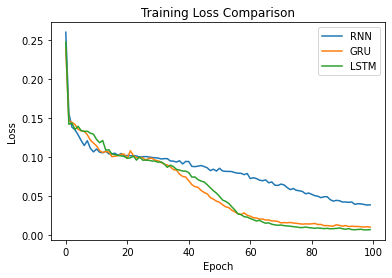

In [38]:
plt.plot(np.arange(100), loss_rnn, label = 'RNN')
plt.plot(np.arange(100), loss_gru, label = 'GRU')
plt.plot(np.arange(100), loss_lstm, label = 'LSTM')
plt.legend()
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')

As expected, GRU and LSTM converges much faster and reached better loss compared to vanilla RNNs due to the issue descrived above, with LSTM having slightly loss than GRU.

**Prediction Visualization on test set**

In [39]:
valRNN = test_dataset.seq[:frame_size].detach().tolist()
valGRU = test_dataset.seq[:frame_size].detach().tolist()
valLSTM = test_dataset.seq[:frame_size].detach().tolist()
for i in range(test_dataset.seq.shape[0] - frame_size):
    dataRNN = torch.tensor(valRNN[-frame_size:]).unsqueeze(-1).unsqueeze(0).to(device)
    dataGRU = torch.tensor(valGRU[-frame_size:]).unsqueeze(-1).unsqueeze(0).to(device)
    dataLSTM = torch.tensor(valLSTM[-frame_size:]).unsqueeze(-1).unsqueeze(0).to(device)
    predRNN = modelRNN(dataRNN)
    predGRU = modelGRU(dataGRU)
    predLSTM = modelLSTM(dataLSTM)
    valRNN.append(predRNN.item())
    valGRU.append(predGRU.item())
    valLSTM.append(predLSTM.item())

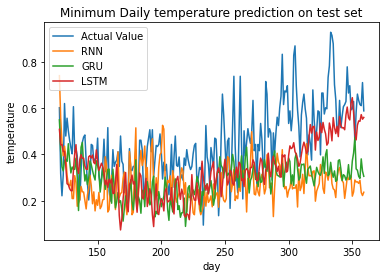

In [41]:
plt.plot(np.arange(test_dataset.seq.shape[0])[frame_size:], test_dataset.seq[frame_size:], label = 'Actual Value')
plt.plot(np.arange(test_dataset.seq.shape[0])[frame_size:], valRNN[frame_size:], label = 'RNN')
plt.plot(np.arange(test_dataset.seq.shape[0])[frame_size:], valGRU[frame_size:], label = 'GRU')
plt.plot(np.arange(test_dataset.seq.shape[0])[frame_size:], valLSTM[frame_size:], label = 'LSTM')
plt.title('Minimum Daily temperature prediction on test set')
plt.xlabel('day')
plt.ylabel('temperature')
plt.legend()
plt.show()

The above visualization is generated by using the first 120 data points in the test set as input, and let the model recurrently predicts the next data points.

At the beginning of the prediction, all three models did a descent job predicting the minimal temperature of the next day. However, as the prediction goes on, we can see RNN and GRU starts to deviate away from the upward trend in the actual value (around day 260), with RNN being worse than GRU. In contrast, LSTM is able to keep up with the upward trend.

**Feed Foward Network for Sequential Data**

Normally, sequential data can not be solved by a simple feed-forward network. This is because a traditional FFN will disregard the order of the sequence, which is one of the fundamental feature in a sequential dataset. 

## Task 2: Word2Vec

I will be using the GloVe word2vec embedding with 50 dimension for this implementation.

**Parse Embedding**

In [42]:
import numpy as np

In [50]:
word2vec = {}
with open('../data/glove.6B/glove.6B.50d.txt', encoding='cp437') as f:
    for row in f:
        data = row.strip().split(' ')
        word2vec[data[0]] = np.array(data[1:], dtype = float)

**Similarity / Dissimilarity Calculator**

In [59]:
def compareWords(a, b):
    vec_a = word2vec.get(a)
    vec_b = word2vec.get(b)
    # compute cosine similarity
    cos_sim = np.dot(vec_a, vec_b)/(np.linalg.norm(vec_a)*np.linalg.norm(vec_b))
    # compute dissimilarity (euclidean distance)
    euc_dis = np.sum(np.sqrt(np.square(vec_a - vec_b)))
    print(f'Similarity: {cos_sim}, Dissimilarity: {euc_dis}')

Examples

In [61]:
compareWords('king', 'queen')

Similarity: 0.7839043010964117, Dissimilarity: 19.848466300000002


In [69]:
compareWords('king', 'men')

Similarity: 0.39326874478591695, Dissimilarity: 33.148742


In [70]:
compareWords('king', 'women')

Similarity: 0.301030146800214, Dissimilarity: 36.9215184


The dissimilarity metrics I used in the above function is just the euclidean distance between the two vectors (0 (alike) ~ inf (very different)). I think this is simple yet effective metric as the farther apart the two word vectors are in the embedding space, the more different in terms of context it should be.